In [432]:
using JuMP, NamedArrays

In [433]:
# Create a plot showing the request with the time window
function plot_Request_Time_Window(passengers)
    figure(figsize=(10,10));
    request_no = length(passengers)
    drop_time_list = []

    for i=1:request_no
        p = passengers[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=8)
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=8) 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](passengers[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [434]:
using PyPlot
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Passenger
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end
type Driver
    cur_pos::Tuple{Int64, Int64}
end

function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_normalized_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end


rand_normalized_xy (generic function with 1 method)

In [435]:
function plot_passenger_driver(passengers, drivers)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r", marker="X")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g", marker = "^")
    scatter(dxs,dys,s=1000,alpha=0.5,color="b", marker = "s")
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end


plot_passenger_driver (generic function with 1 method)

In [688]:
function genGrid(n_passenger, n_driver)
    passengers = Passenger[]
    drivers = Driver[]
    ptime = sort(rand(50:1000,n_passenger))
    for i=1:n_passenger
        ppos = rand_xy()
        dpos = rand_xy()
        p = Passenger(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(passengers, p)
    end
    for i=1:n_driver
        d = Driver((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(drivers, d)
    end
    plot_passenger_driver(passengers, drivers)   #### Function call to plot 
    for p in passengers
        println(p)
    end
    plot_Request_Time_Window(passengers)
    return passengers,drivers
end

genGrid (generic function with 1 method)

In [490]:
# Function to Get the coordinates of all depot and pickup, drop locations of requests (in order of request)
# Can be modified to be called within distance matrix

function getLocations(depot, requests)
    nodes = []
    for d in depot             # Right now, considering only single depot.
        depot_node = d.cur_pos
        push!(nodes, depot_node)
    end

    for r in requests
        push!(nodes, r.pickup_pos)
        push!(nodes, r.dropoff_pos)
    end
    return nodes
end

getLocations (generic function with 1 method)

# Generating distance matrix 

In [491]:
# Generating distance matrix.
 
function distance_matrix(nodes, numReq)
    
    # Creating names for nodes
    numReq = length(requests)
    points = []
    i = 0
    push!(points,"Depot")
    for r in 1:numReq
        i = i+1
        pickup = string("P_",i)
        drop = string("D_",i)
        push!(points,pickup)
        push!(points,drop)
    end
    println(points)

    # Compute distance matrix for the Agencies
    pointA = nodes
    pointB = copy(nodes)

    nodeLen = length(nodes) # nodes include pickup, dropoff and depot

    D = zeros(nodeLen,nodeLen)

    for j = 1:nodeLen
            for i = 1:nodeLen
                D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
            end
    end
    #println("Distance matrix : ",D)
    println("")

    dist_matrix =  NamedArray(D,(points,points),("From","To"))
    #show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
    #points
    return dist_matrix
end

distance_matrix (generic function with 1 method)

In [492]:
function plot_car_route(passengers, drivers, x_request_to_cab)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    # Plost route line for each cab
    for k = 1:K
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        for r = 1:R
            if x_request_to_cab[r, k] > 0
                request = passengers[r]
                
                pp_x = request.pickup_pos[1]
                pp_y = request.pickup_pos[2]
                dp_x = request.dropoff_pos[1]
                dp_y = request.dropoff_pos[2]
                hlines(y=pp_y, xmin=pp_x, xmax=dp_x, color=color_val)
                vlines(x=dp_x, ymin=pp_y, ymax=dp_y, color=color_val)
                
                time_stamp = string("[Cab #", k, "]")
                if dp_y > pp_y
                    plot(dp_x, dp_y, marker="^", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y < pp_y
                    plot(dp_x, dp_y, marker="v", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y == pp_y && dp_x < pp_x
                    plot(dp_x, dp_y, marker="<", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                elseif dp_y == pp_y && dp_x > pp_x
                    plot(dp_x, dp_y, marker=">", color=color_val, markersize = 20)
                    text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                end
            end
        end
    end
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end

plot_car_route (generic function with 1 method)

In [493]:
function plot_car_route_v2(passengers, drivers, mask)    
    
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(20,20) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    # Plot route line for each cab
    for k = 1:K
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        
        for p = 1:2R+1
            for d = 1:2R+1

                if mask[p, d, k] > 0
                    if p+1 == d && p%2 == 0
                        request = passengers[Int8(round(p/2))]

                        pp_x = request.pickup_pos[1]
                        pp_y = request.pickup_pos[2]
                        dp_x = request.dropoff_pos[1]
                        dp_y = request.dropoff_pos[2]
                        
                        hlines(y=pp_y, xmin=pp_x, xmax=dp_x, color=color_val)
                        vlines(x=dp_x, ymin=pp_y, ymax=dp_y, color=color_val)
                    else
                        start_between_req = passengers[Int8(round((p-1)/2))]
                        end_between_req = passengers[Int8(round(d/2))]
                        
                        pp_x = start_between_req.dropoff_pos[1]
                        pp_y = start_between_req.dropoff_pos[2]   
                        dp_x = end_between_req.pickup_pos[1]
                        dp_y = end_between_req.pickup_pos[2]
                        
                        x_min = minimum([pp_x, dp_x])
                        x_max = maximum([pp_x, dp_x])
                        x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                        plot(x_range, y_range, color=color_val, linestyle="--")
                        
                        y_min = minimum([pp_y, dp_y])
                        y_max = maximum([pp_y, dp_y])
                        y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                        plot(x_range, y_range, color=color_val, linestyle="--")
                    end
                    
                    time_stamp = string("[Cab #", k, "]")
                    if dp_y > pp_y
                        plot(dp_x, dp_y, marker="^", color=color_val, markersize = 20)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                    elseif dp_y < pp_y
                        plot(dp_x, dp_y, marker="v", color=color_val, markersize = 20)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                    elseif dp_y == pp_y && dp_x < pp_x
                        plot(dp_x, dp_y, marker="<", color=color_val, markersize = 20)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                    elseif dp_y == pp_y && dp_x > pp_x
                        plot(dp_x, dp_y, marker=">", color=color_val, markersize = 20)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val)
                    end
                end
                
            end
        end
    end
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end

plot_car_route_v2 (generic function with 1 method)

# VRP Model Test

Passenger((4, 18), 228, (26, 7), 33)
Passenger((39, 16), 376, (6, 2), 47)
Passenger((35, 5), 449, (4, 35), 61)
Passenger((8, 26), 833, (23, 13), 28)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4"]




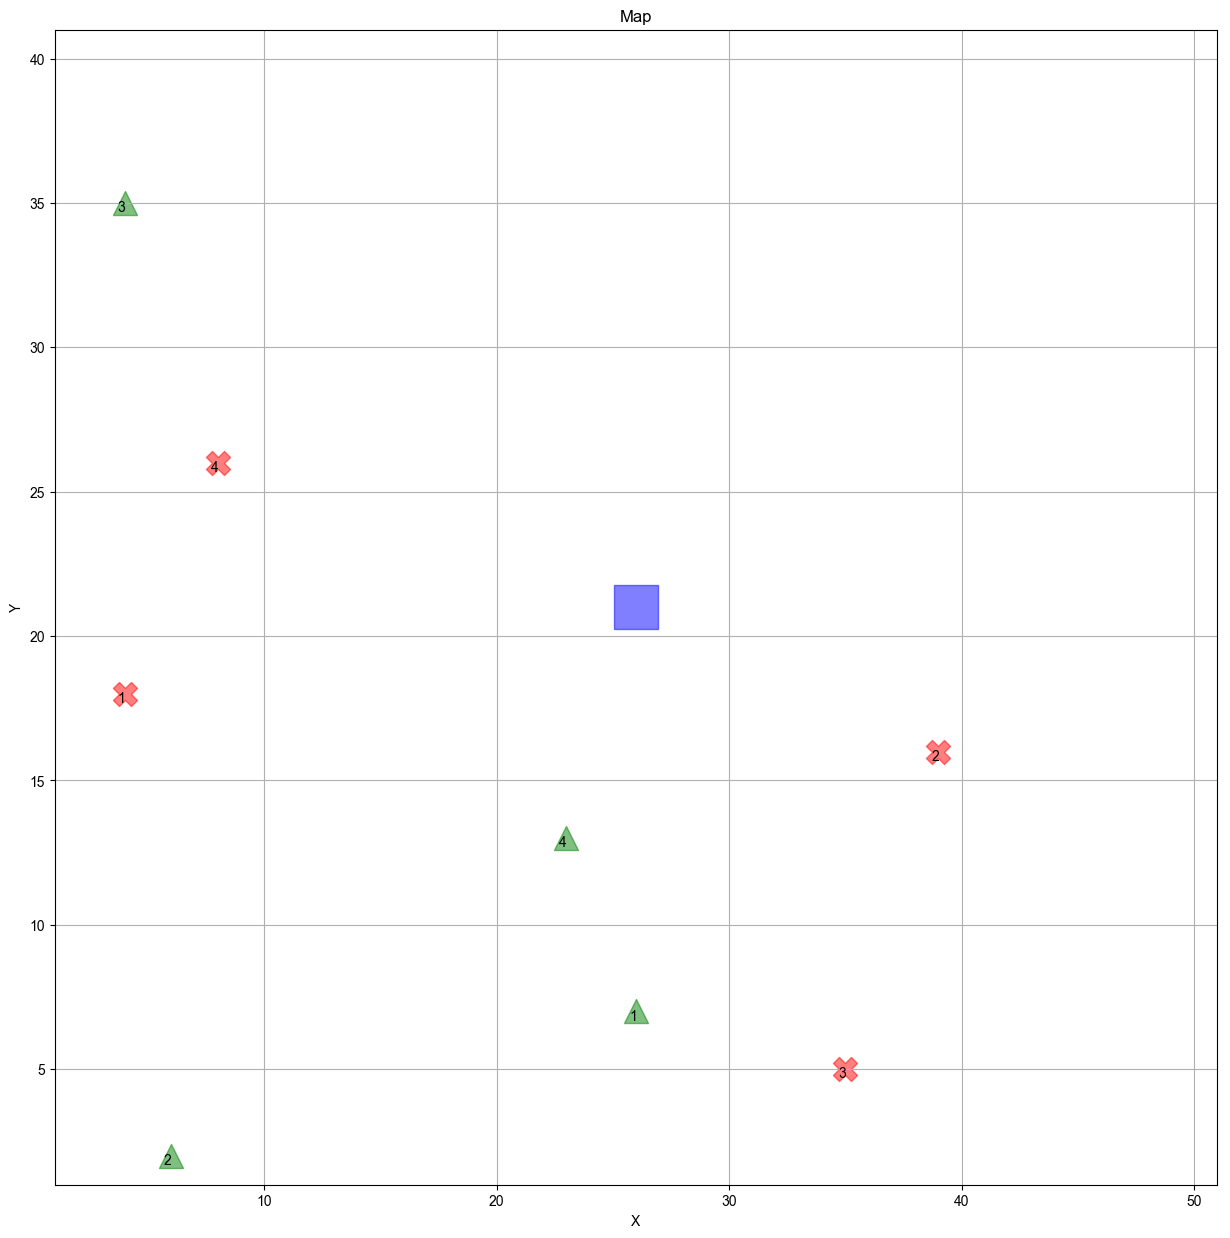

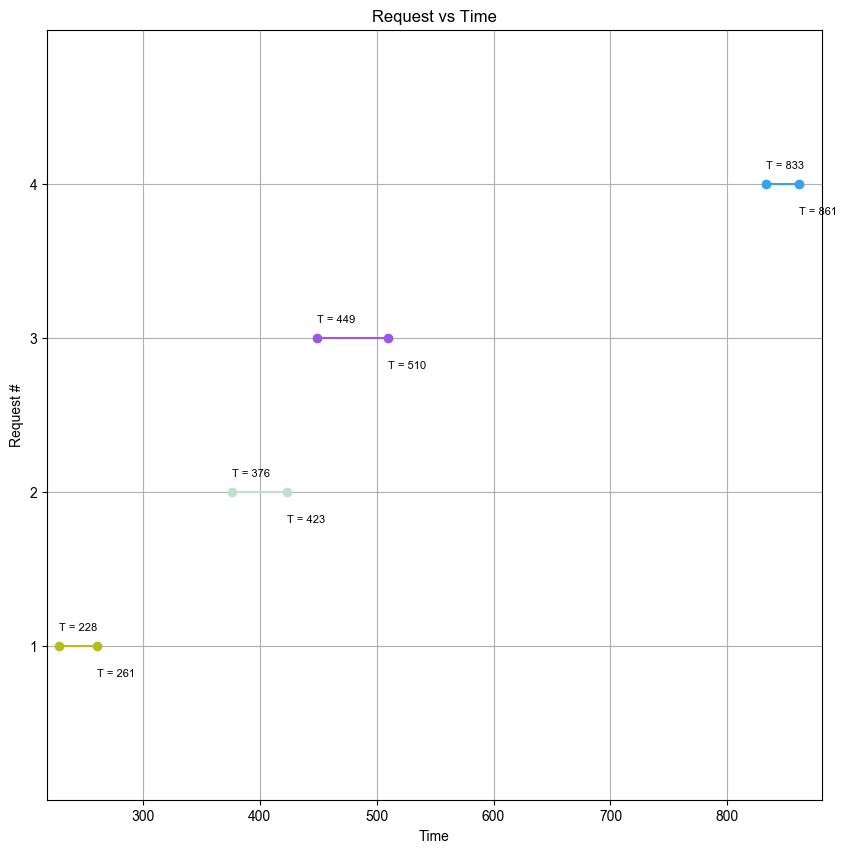

Passenger((4, 18), 228, (26, 7), 33)
Passenger((39, 16), 376, (6, 2), 47)
Passenger((35, 5), 449, (4, 35), 61)
Passenger((8, 26), 833, (23, 13), 28)

pickup time = Any[228, 376, 449, 833]
pickup location = Any[(4, 18), (39, 16), (35, 5), (8, 26)]
dropoff time = Any[261, 423, 510, 861]
dropoff location = Any[(26, 7), (6, 2), (4, 35), (23, 13)]
duration = Any[33, 47, 61, 28]


In [689]:
# Parameter
R = 4 # Number of requests
requests, depot = genGrid(R, 1)
nodes = getLocations(depot, requests)
dist_map = distance_matrix(nodes, length(requests));

p_t = []
p_l = []
d_t = []
d_l = []
duration = []

println("")
for r = 1:R
    println(requests[r])
    
    push!(p_t, requests[r].pickup_time)
    push!(p_l, requests[r].pickup_pos)
    push!(d_t, requests[r].pickup_time + requests[r].duration)
    push!(d_l, requests[r].dropoff_pos)
    push!(duration, requests[r].duration)
end

println("")
println("pickup time = ", p_t)
println("pickup location = ", p_l)
println("dropoff time = ", d_t)
println("dropoff location = ", d_l)
println("duration = ", duration)

In [691]:
K = 1 # Number of cars
small_m = minimum(p_t) - maximum(d_t) - maximum(dist_map)
println("small_m = ", small_m)
Big_M = sum(dist_map)
println("Big_M = ", Big_M)
epsilon = 1
small_m2 = 0
small_m3 = -1
lambda = 100###############
theta = -1
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, y[1:K], Bin)
@variable(m, x[1:R, 1:K], Bin)
@variable(m, mask[1:2R+1, 1:2R+1, 1:K], Bin)
@variable(m, more2[1:R, 1:R, 1:K], Bin)
@variable(m, less2[1:R, 1:R, 1:K], Bin)
@expression(m, d[k in 1:K], sum(dist_map[p, d] * mask[p, d, k] for p in 1:2R+1, d in 1:2R+1))

@variable(m, temp[1:R, 1:R, 1:K], Bin)
@variable(m, temp2[1:R, 1:R, 1:K], Bin)

## Depot to pickup variables
#@variable(m, sum1[1:R, 1:K]) ## Integer 
#@variable(m, sum2[1:R, 1:K])# Integer
#@variable(m, temp3[1:R, 1:K], Bin)
#@variable(m, temp4[1:R, 1:K], Bin)

#for k = 1:K 
#    for r = 1:R
#        @expression(m, sum1[r,k] = sum(x[i,k] for i in 1:r))
        
#    end
#    for r = 1:R
#        @constraint(m, sum1[r,k] - 1 <= R*temp3[r,k] - theta*(1-temp3[r,k]))) # R is the upper bound
#    end
#    for r = 1:R
#        @expression(m, sum2[r,k] = sum(sum1[i,k] for i in 1:r))
#       
#    end
#end
        

for r1 = 1:R-1
    for r2 = (r1+1):R
        for k = 1:K
            @constraint(m, sum(x[r1:r2,k])-2 <= (R-2)*more2[r1, r2, k]-(1-more2[r1, r2, k]))
            @constraint(m, sum(x[r1:r2,k])-2 >= (-2)*less2[r1, r2, k]+(1-less2[r1, r2, k]))
        end
    end
end



@constraint(m, constraint1[r in 1:R], sum(x[r, k] for k =1:K) == 1)

for r = 1:R
    for k = 1:K
        @constraint(m, mask[2r, 2r+1, k] - 1 >= small_m3*(1 - x[r, k]))
    end
end

for k = 1:K
    @constraint(m, d[k] <= Big_M * y[k])
    @constraint(m, d[k] >= small_m2 * (1 - y[k]) + epsilon*y[k])
end

for r1 = 1:R-1
    for r2 = (r1+1):R
        for k = 1:K
            @constraint(m, p_t[r2] - d_t[r1] - dist_map[2*r2, 2*r1+1] >= small_m*(1 - x[r1, k]*x[r2, k]))
            #@constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - (x[r1, k]*x[r2, k])))
            @constraint(m, temp2[r1, r2, k] - 1 >= small_m3*(1 - (x[r1, k]*x[r2, k])))
            @constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - temp[r1, r2, k]*temp2[r1, r2, k]))
           
            
            @constraint(m, temp[r1, r2, k] - 1 >= small_m3*(1-more2[r1, r2, k]*less2[r1, r2, k]))
            #@constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1-more2[r1, r2, k]*less2[r1, r2, k]))  ## hannah
        end
    end
end

for p_idx in 1:2R+1
    for d_idx in 1:2R+1
        @constraint(m, sum(mask[p_idx, d_idx, k] for k in 1:K) <= 1)
    end
end

for k = 1:K
    for p_idx in 1:2R+1
        @constraint(m, sum(mask[p_idx, d_idx, k] for d_idx in 1:2R+1) <= 1)
    end
end

@objective(m, Min, sum(lambda*y + d))

status = solve(m)

#println(m)
println(status)
println("Optimum = ", getobjectivevalue(m))
println("y = ", getvalue(y))

println("x = ")
for r = 1:R
    println(getvalue(x)[r, 1:K])
end


println("mask = ")
mask_best = getvalue(mask)
for k = 1:K
    for p_idx in 1:2R+1
        #println(mask_best[p_idx, 1:2R+1, k])
    end
    println("")
end
println("d = ", getvalue(d))
println(sum(getvalue(d)))

small_m = -694.0
Big_M = 2076.0


Academic license - for non-commercial use only
Infeasible
Optimum = NaN
y = [NaN]
x = 
[NaN]
[NaN]
[NaN]
[NaN]
mask = 

d = [NaN]
NaN


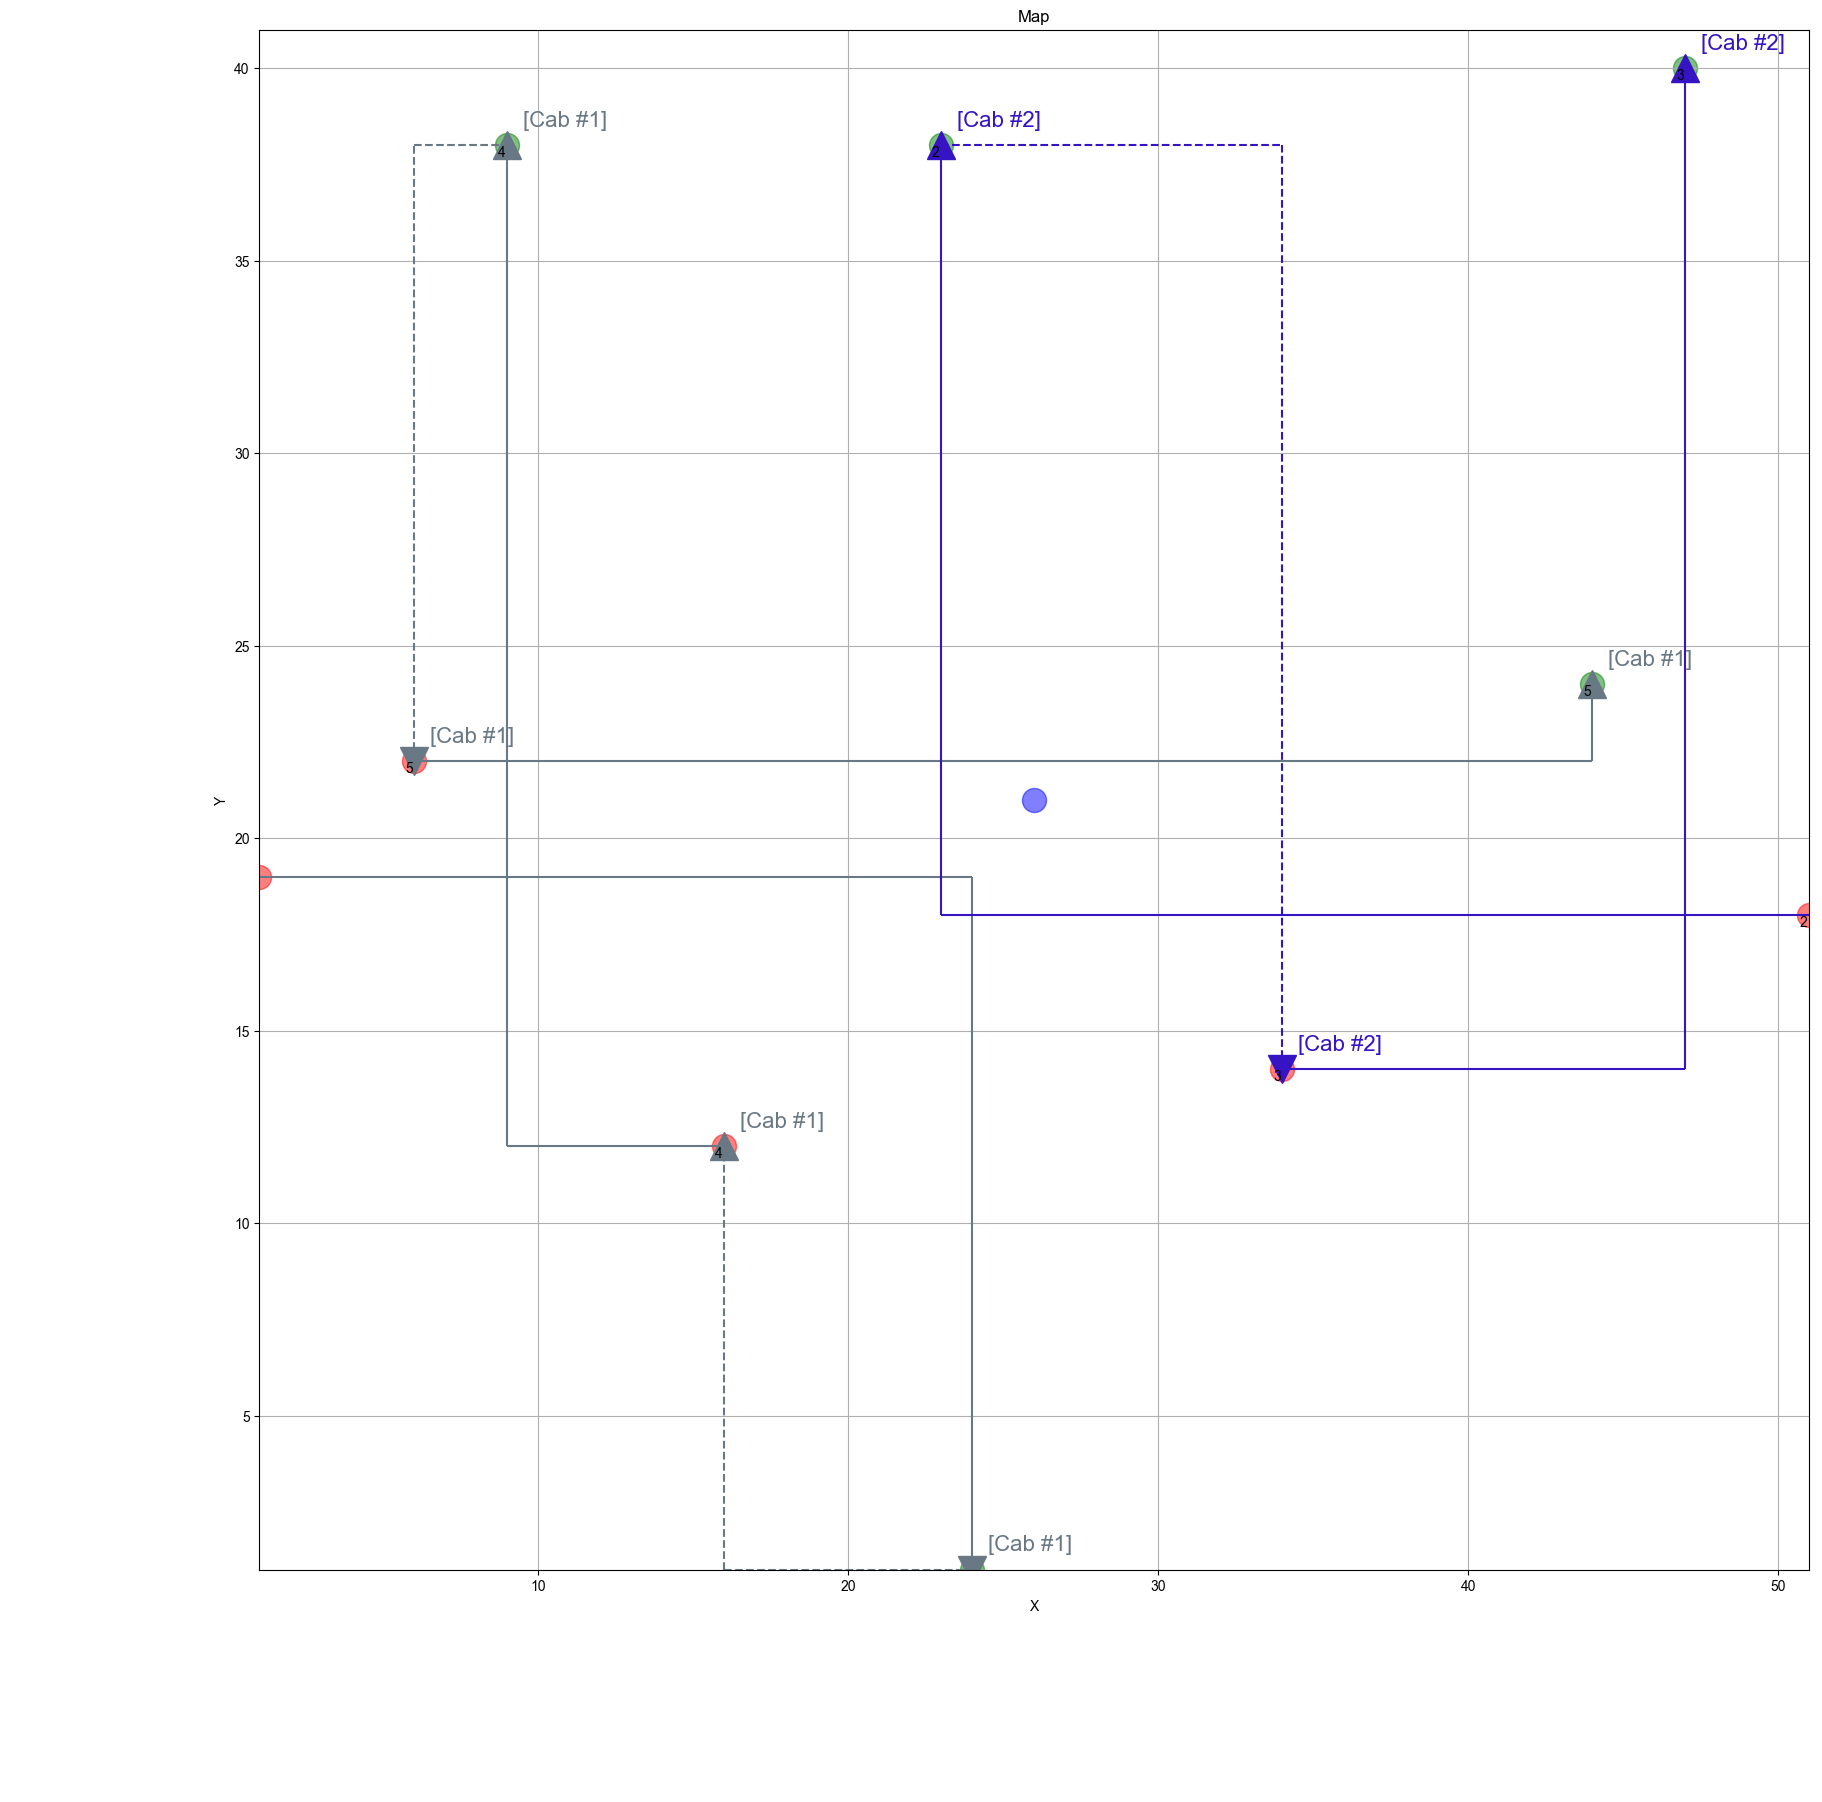

In [683]:
#plot_car_route(requests, depot, getvalue(x))
plot_car_route_v2(requests, depot, mask_best)

In [662]:
car = "\U0001F4A7"

"💧"

In [211]:
car

"💧"

In [ ]:
using PyCall, PyPlot
@pyimport matplotlib.patches as mpatch
@pyimport matplotlib.pyplot as mplt
cfig = figure()
bb = [[0.3, 0.4], [0.7, 0.6]]
ax = cfig[:add_subplot](1,1,1)
#ax = mplt.subplot(2, 2, 1)
p_fancy = mpatch.FancyBboxPatch((3,4),
                             1,1,
                             boxstyle="Square,pad=0.1",
                            ec="k", fc="w", zorder=10.)

ax[:add_artist](p_fancy)
ylim(ymin = 0, ymax = 10)
xlim(xmin = 0, xmax = 10)
show()
s = "🚗"
#styles = mpatch.BoxStyle("Square")
#mpatch.FancyBboxPatch(1,3, 5, 5, boxstyle="round,pad=0.1")
text(3,5.5,s,fontsize="16")
show()
#using UnicodeExtras
#car = "🚗".encode("utf-8")

In [ ]:
using PyCall
using PyPlot
@pyimport matplotlib.animation as anim# First set up the figure, the axis, and the plot element we want to animate
fig = figure()
ax = cfig[:add_subplot](1,1,1)
#ax = PyPlot.axes(xlim=(0, 2), ylim=(-2, 2))
global line = ax[:plot]([], [], lw=2)[1]

# initialization function: plot the background of each frame
function init()
    global line
    line[:set_data]([], [])
    return (line,None)
end
# animation function.  This is called sequentially
function animate(i)
    x = linspace(0, 2, 1000)
    y = sin(2 * pi * (x - 0.01 * i))
    global line
    line[:set_data](x, y)
    return (line,None)
end

# call the animator.  blit=True means only re-draw the parts that have changed.
myanim = anim.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=true)
fig.show()
#myanim[:save]("/tmp/sinplot.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

# call our new function to display the animation
#display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
                            base64(open(readbytes,"/tmp/sinplot.mp4")),"""" type="video/mp4"></video>"""))